# ECE 450 - Exam #1

# Code Appendix

---

## Package Imports


In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


## Generic Function for a State Variable Solver


In [2]:
def state_solver(A_matrix, B_matrix, force_function, initial_conditions,
                 time_range=[0, 10], dt=0.01):
    time_values = np.arange(time_range[0], time_range[1], dt)
    x_vals = np.array(initial_conditions)
    state_variables = [[] for _ in initial_conditions]
    
    # Loop through each instance in time, calculate the state variable at that time
    for time in time_values:
        # For multiple input functions, do matrix operations on the 2nd term
        if isinstance(force_function, list):
            force_vals = np.array([func(time) for func in force_function])
            x_vals = x_vals + dt * (A_matrix @ x_vals) + dt * (B_matrix @ force_vals)
        else:
            x_vals = x_vals + dt * (A_matrix @ x_vals) + dt * (B_matrix * force_function(time))
        # Add the value of the state variable at this time to the list
        for index, _ in enumerate(state_variables):
            state_variables[index].append(x_vals[index])
            
    return state_variables, time_values


## Generic Function for Creating Combined `DataFrame` out of State Variables, Input Function, and Output Function


In [3]:
def create_df(time, state_variables, input_fs, output_f, state_names, input_names):
    df_list = []
    # If there is only one input, create an array out of it anyway (for looping)
    input_fs = input_fs if isinstance(input_fs, (list, np.ndarray)) else [input_fs]
    # For each input function, compute the time-values and add to the DF list
    for input_f, name in zip(input_fs, input_names):
        input_vals = [input_f(t) for t in time]
        df = pd.DataFrame(list(zip(time, input_vals)), columns=["Time", "Value"])
        df["Name"] = name             # Name the solution column
        df["Type"] = "Input Functions" if len(input_fs) > 1 else "Input Function"
        df_list.append(df)
    
    # Loop through every state variable, add its time and output to a list of dataframes
    for state_var, name in zip(state_variables, state_names):
        df = pd.DataFrame(list(zip(time, state_var)), columns=["Time", "Value"])
        df["Name"] = name              # Name the solution column
        df["Type"] = "State Variables" # The 'type' of this DF
        df_list.append(df)
            
    # Add the output to the DF list
    output_vals = output_f(state_variables)
    df = pd.DataFrame(list(zip(time, output_vals)), columns=["Time", "Value"])
    df["Name"] = "Output"          # Name of the instance
    df["Type"] = "Output Function" # The 'type' of this DF
    df_list.append(df)
        
    return pd.concat(df_list, ignore_index=True, axis=0)


## Generic Function to create the Three Necessary Plots


In [4]:
def create_plots(df):
    sns.set(style="whitegrid", font_scale=2.25)
    g = sns.FacetGrid(df, hue="Name", row="Type", height=5.5, aspect=4, sharey=False)
    g.map(sns.lineplot, "Time", "Value", **dict(linewidth=2.5)).add_legend().despine(bottom=True, left=True)
    
    return g


## My Solution


In [8]:
A_matrix = np.array([[-20,    0,   0,  0],
                     [  0,    0,   1,  0],
                     [400, -400, -10,  0],
                     [  0,  -20,   0, -5]])
B_matrix = np.array([[  1, 0],
                     [  0, 0],
                     [-20, 0],
                     [  0, 1]])
init_state = [0, 0, 0, 0]

step = lambda time: 0 if time < 0 else 1
f = lambda time: 5 * np.sin((2 * np.pi * time)/30) * (step(time) - step(time - 1))
g = lambda time: 10 * np.sin((2 * np.pi * (time - 1))/50) * (step(time - 1) - step(time - 2))
input_funcs = [f, g]
output_func = lambda states: [x4 for x1, x2, x3, x4 in zip(states[0], states[1], states[2], states[3])]

state_vars, time = state_solver(A_matrix, B_matrix, input_funcs, init_state, [0, 2.5], 0.001)


#### Plot the state variables over time


In [9]:
state_var_names = ["$x_1(t)$", "$x_2(t)$", "$x_3(t)$", "$x_4(t)$"]
input_names = ["$f(t)$", "$g(t)$"]
df = create_df(time, state_vars, input_funcs, output_func, state_var_names, input_names)


#### Plot the results


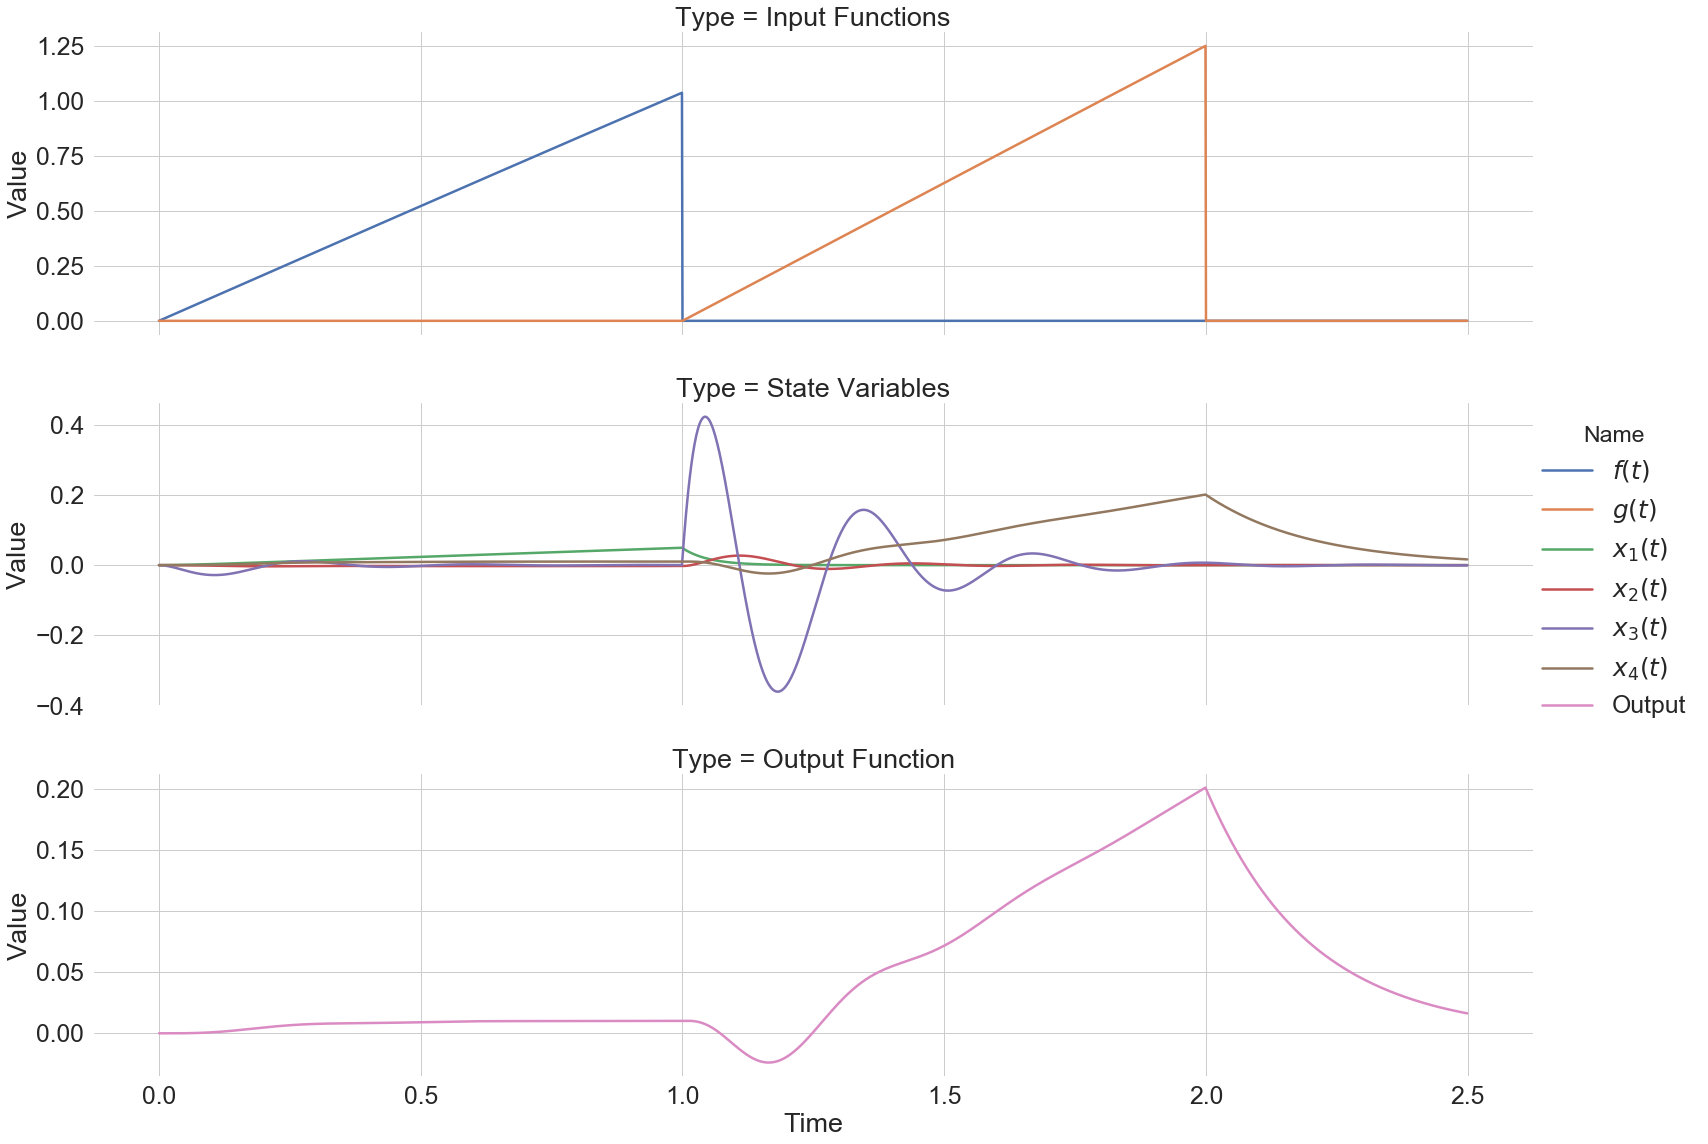

In [10]:
g = create_plots(df)

In [11]:
g.savefig("output-graph.png", dpi=500)